<a href="https://colab.research.google.com/github/Himanshu0508Raturi/deepFake-API/blob/main/deepfake_detector_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
with tf.device('/GPU:0'):
    model = ...  # Load or build your model


In [ ]:
import kagglehub
import os
import pandas as pd

# Download the dataset and get the local path
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
print("Downloaded dataset path:", path)

# List all files and directories inside the downloaded dataset
print("Contents of downloaded folder:", os.listdir(path))

# Find actual dataset directory (e.g., it may not have a "Dataset" folder)
for root, dirs, files in os.walk(path):
    print("Checking directory:", root)
    if "Train" in dirs and "Validation" in dirs and "Test" in dirs:
        dataset_root = root
        break

# Now assign paths based on the actual dataset directory structure
train_directory = os.path.join(dataset_root, "Train")
val_directory = os.path.join(dataset_root, "Validation")
test_directory = os.path.join(dataset_root, "Test")

print("Train folder:", train_directory)
print("Validation folder:", val_directory)
print("Test folder:", test_directory)

# Check image distribution
categories = os.listdir(train_directory)
nums = {label: len(os.listdir(os.path.join(train_directory, label))) for label in categories}
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of Images"])
print("Image Distribution:\n", img_per_class)


Downloaded dataset path: /kaggle/input/deepfake-and-real-images
Contents of downloaded folder: ['Dataset']
Checking directory: /kaggle/input/deepfake-and-real-images
Checking directory: /kaggle/input/deepfake-and-real-images/Dataset
Train folder: /kaggle/input/deepfake-and-real-images/Dataset/Train
Validation folder: /kaggle/input/deepfake-and-real-images/Dataset/Validation
Test folder: /kaggle/input/deepfake-and-real-images/Dataset/Test
Image Distribution:
       No. of Images
Fake          70001
Real          70001


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pathlib
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
import seaborn as sns
import os
import pandas as pd

In [ ]:
import os

base_path = "/kaggle/input/deepfake-and-real-images/Dataset"

train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
val_path = os.path.join(base_path, "Validation")

print("Train folder:", train_path)
print("Test folder:", test_path)
print("Validation folder:", val_path)


Train folder: /kaggle/input/deepfake-and-real-images/Dataset/Train
Test folder: /kaggle/input/deepfake-and-real-images/Dataset/Test
Validation folder: /kaggle/input/deepfake-and-real-images/Dataset/Validation


In [ ]:
train_directory = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
val_directory = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
test_directory = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

In [ ]:
categories = os.listdir(train_directory)
nums = {label: len(os.listdir(os.path.join(train_directory, label))) for label in categories}
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of Images"])
print("Image Distribution:\n", img_per_class)

Image Distribution:
       No. of Images
Fake          70001
Real          70001


In [ ]:
# Define image dimensions and batch size
img_height, img_width = 180, 180
batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1,
    label_mode='binary'
)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Device Name:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
Num GPUs Available: 1
GPU Device Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Load ResNet50 base model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(384, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # or Dense(2, softmax) if categorical
])


In [ ]:
# Compile model
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 6, 6, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │       786,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,374,913 (92.98 MB)

 Trainable params: 787,201 (3.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('Resnet50.keras', save_best_only=True)
]

In [ ]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 555s 124ms/step - accuracy: 0.7807 - loss: 0.4630 - val_accuracy: 0.8107 - val_loss: 0.4120
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 351s 77ms/step - accuracy: 0.8223 - loss: 0.3838 - val_accuracy: 0.7850 - val_loss: 0.4517
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 383s 77ms/step - accuracy: 0.8333 - loss: 0.3677 - val_accuracy: 0.8303 - val_loss: 0.3787
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 368s 74ms/step - accuracy: 0.8393 - loss: 0.3552 - val_accuracy: 0.8369 - val_loss: 0.3615
Epoch 5/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 336s 77ms/step - accuracy: 0.8413 - loss: 0.3489 - val_accuracy: 0.8413 - val_loss: 0.3615
Epoch 6/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 368s 74ms/step - accuracy: 0.8456 - loss: 0.3400 - val_accuracy: 0.8289 - val_loss: 0.3859
Epoch 7/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 397s 77ms/step - accuracy: 0.8517 - loss: 0.3314 - val_accuracy: 0.8418 - val_loss: 0.3570
Epoch 8/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 381s 77ms/step - accuracy:

In [ ]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"\nOverfitting Gap: {val_acc - train_acc:.4f}")
print(train_acc)
print(val_acc)


Overfitting Gap: -0.0228
0.8585520386695862
0.8358019590377808


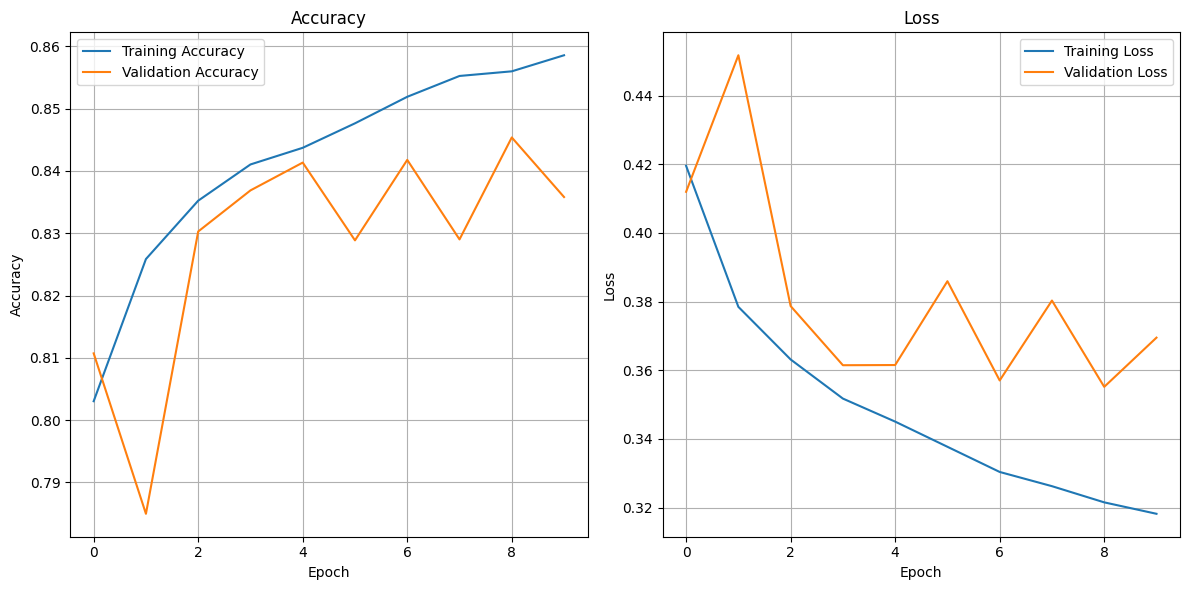

In [ ]:
# Plot metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

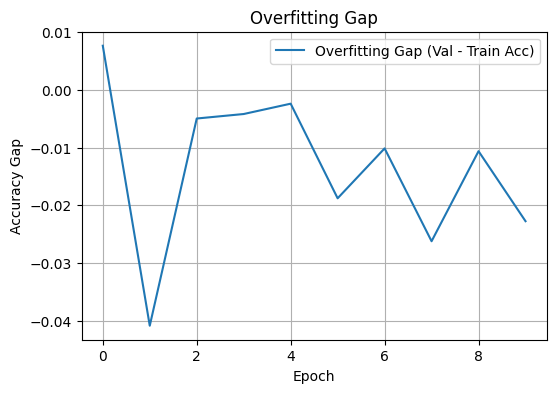

In [ ]:
# Overfitting Gap Visualization
val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
overfitting_gap = [v - t for v, t in zip(val_acc, train_acc)]
plt.figure(figsize=(6, 4))
plt.plot(overfitting_gap, label='Overfitting Gap (Val - Train Acc)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap')
plt.title('Overfitting Gap')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('resnet50_model_explicit.h5')
model.save("resnet50_model_explicit.keras")